In [52]:
from google.colab import drive
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

# **First we import the dataset**

In [53]:
drive.mount('/content/gdrive')
file_path = "/content/gdrive/MyDrive/Colab Notebooks/Forecasting_Project/output.xlsx"

dirty_df = pd.read_excel(file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ---------------------------------------------------------------------------------------------------------------------------------------------

# **1. DATA EXPLORATION AND PREPROCESSING**

## **a. DATA CLEANING**

### Check if there are blanks, which indeed it does

---


In [54]:
blank_count = dirty_df.isna().sum()
print(blank_count)

date                     0
product_ID               0
quantity_sold            0
sales_price              0
Category                 0
customer_ID              0
age                      0
gender                   0
purchase_frequency       0
total_purchase_amount    0
profit                   0
dtype: int64


### Remove duplicates and also blanks in Product_ID column

In [55]:
df = dirty_df.drop_duplicates()
df = df.dropna(subset=['product_ID'])

### Replace the missing values in "quantity_sold" and "total_purchase_amount" with the average of these columns.

In [56]:
avg_q_sold = math.ceil(df['quantity_sold'].mean())
avg_purchase_amount = math.ceil(df['total_purchase_amount'].mean())

df['quantity_sold'].fillna(avg_q_sold, inplace=True)
df['total_purchase_amount'].fillna(avg_purchase_amount, inplace=True)

### Confirm blanks

In [57]:
blank_count = df.isna().sum()
print(blank_count)

date                     0
product_ID               0
quantity_sold            0
sales_price              0
Category                 0
customer_ID              0
age                      0
gender                   0
purchase_frequency       0
total_purchase_amount    0
profit                   0
dtype: int64


### Export the new dataframe

In [58]:
# excel_filename = 'output.xlsx'
# df['date'] = pd.to_datetime(df['date'])
# df['date'] = df['date'].dt.strftime('%m/%d/%Y')


# df.to_excel(excel_filename, index=False)

# print(f'DataFrame exported to {excel_filename}')

## ---------------------------------------------------------------------------------------------------------------------------------------------

## HEAD

In [59]:
df.head()

,date,product_ID,quantity_sold,sales_price,Category,customer_ID,age,gender,purchase_frequency,total_purchase_amount,profit
0,01/01/2020,22,112,44,Electronics,1,25,m,1,1132,4928
1,01/02/2020,32,323,7,Clothing,2,33,m,5,2233,2261
2,01/03/2020,11,223,55,Furniture,3,52,f,6,2332,12265
3,01/04/2020,33,43,74,Grocery,4,29,m,8,5432,3182
4,01/05/2020,26,643,39,Stationery,5,36,m,5,5544,25077


## -----------------------------------------------------------------------------------------------------------------------------------------

## **b. EXPLORATORY DATA ANALYSIS (EDA)**

### Insights on Categories

> The most selling category is likely to contribute significantly to the overall revenue. Understanding the revenue distribution across categories helps in focusing marketing efforts and promotions on high-revenue-generating products.

> The "Grocery" category had the highest sold quantity that clearly well above the other categories, which suggests a high demand in grocery products. While "Furniture" had the least demand.

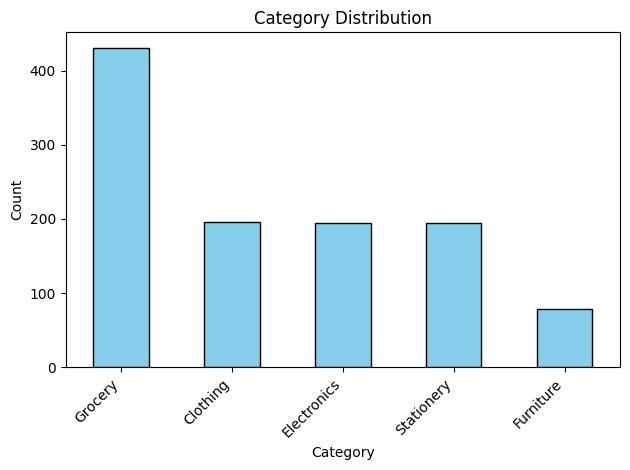

In [60]:
category_counts = df["Category"].value_counts()

# Plot as a histogram
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

> Although knowing the most demanded category could be benefitial in inventory aspects and costumer behavior, the most profitable category over time on the other hand could prove more valuable to organizational goals.

> Insights into the most profitable category guide strategic decision-making. For example, businesses may decide to expand product offerings in the profitable category or invest more in marketing and promotions for those products.

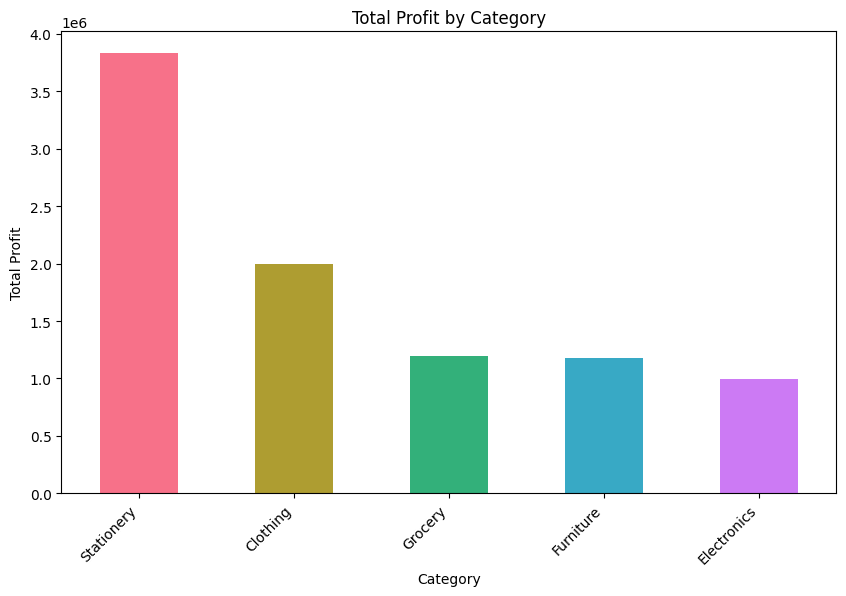

In [61]:
category_profit = df.groupby('Category')['profit'].sum().sort_values(ascending=False)

colors = sns.color_palette("husl", n_colors=len(category_profit))

plt.figure(figsize=(10, 6))

category_profit.plot(kind='bar', color=colors)

plt.title('Total Profit by Category')
plt.xlabel('Category')
plt.ylabel('Total Profit')
plt.xticks(rotation=45, ha='right')
plt.show()

> Categories with a wide range of average prices might suggest different levels of product differentiation. Some categories may have diverse products catering to various consumer needs and preferences.

> Now clearly they all have nearly equal average selling prices, and we learned that "Grocery" has significantly higher demand and "Stationary" yielded more profit, so this suggests that demand is not primarily driven by price differences.

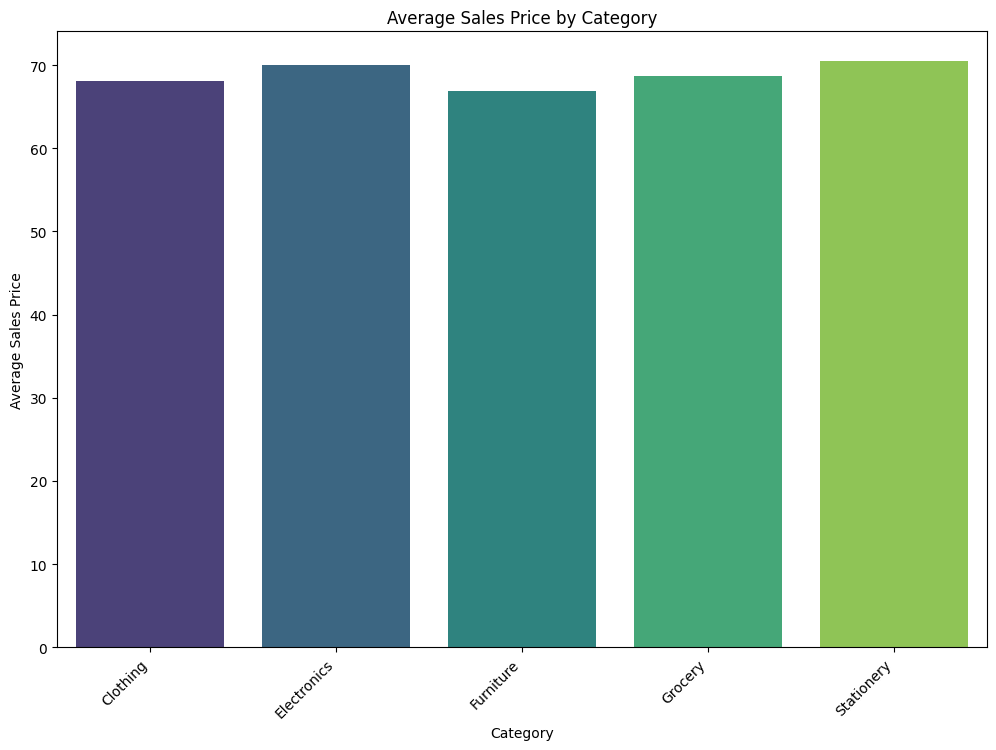

In [62]:
# Calculate the average sales price for each category
avg_sales_price = df.groupby('Category')['sales_price'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='sales_price', data=avg_sales_price, palette='viridis')
plt.title('Average Sales Price by Category')
plt.xlabel('Category')
plt.ylabel('Average Sales Price')
plt.xticks(rotation=45, ha='right')
plt.show()

### Age Insights

> Knowing the dominant age allows for tailored marketing strategies like creating campaigns, promotions, or products that specifically appeal to individuals in the age group that buys the most.

> The age group "23" bought the most, but nearly equally to "36" and "29"

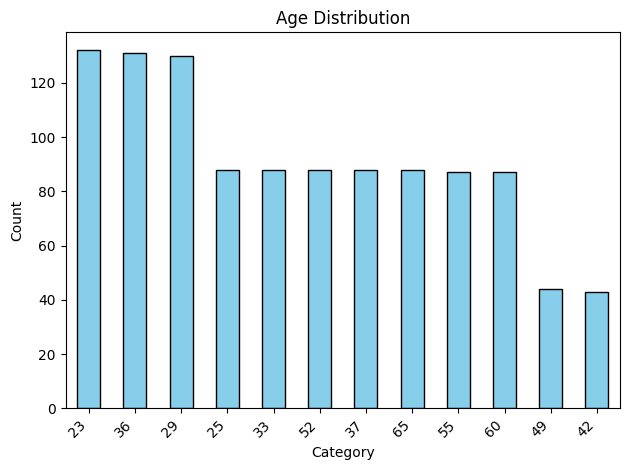

In [63]:
age_counts = df["age"].value_counts()

# Plot as a histogram
age_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Age Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

> Consequently, we want to see which category the highest age groups bought the most to know which category we should focus the most on marketing and other organizational goals.

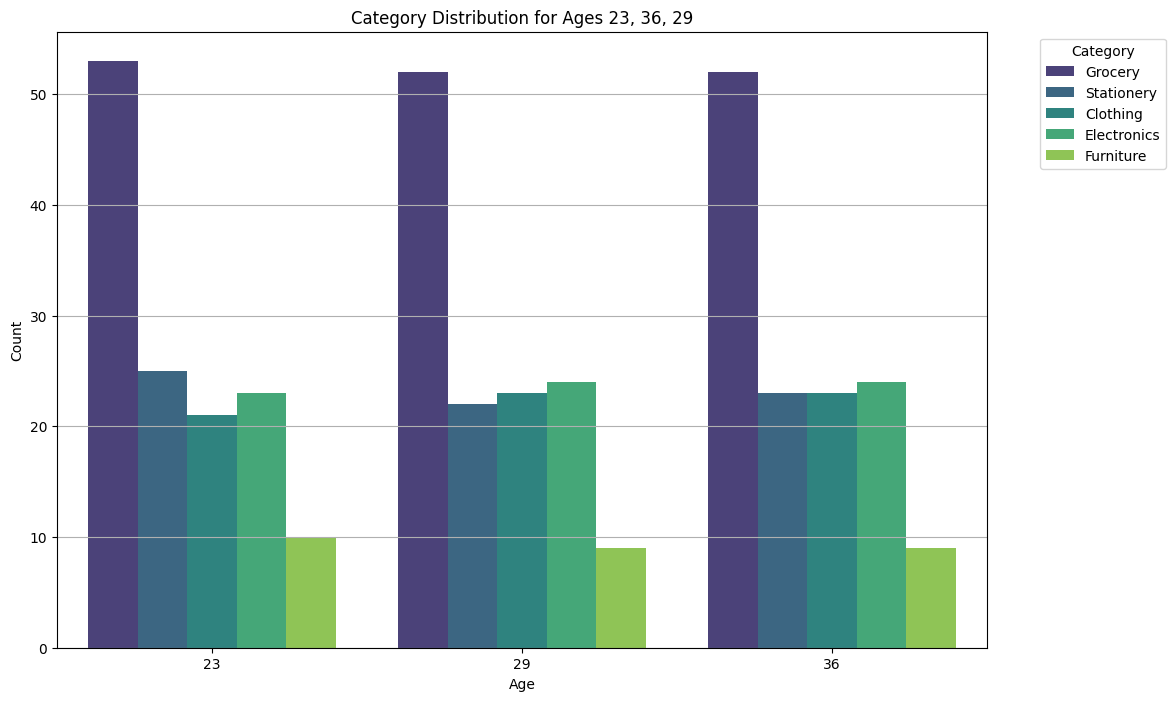

In [64]:
selected_ages = [23, 36, 29]
df_selected_ages = df[df['age'].isin(selected_ages)]

plt.figure(figsize=(12, 8))
sns.countplot(data=df_selected_ages, x='age', hue='Category', palette='viridis')
plt.title('Category Distribution for Ages 23, 36, 29')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

### Gender Distribution

> Tailoring the customer experience based on the predominant gender can enhance customer satisfaction. This includes aspects such as the design of the shopping environment, customer service interactions, and overall shopping experience.

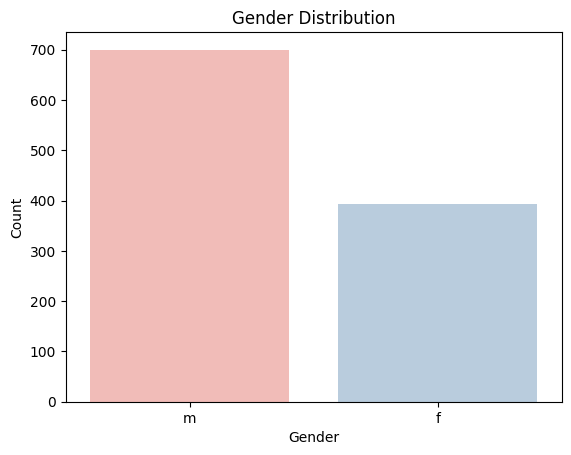

In [65]:
sns.countplot(x='gender', data=df, palette='Pastel1')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

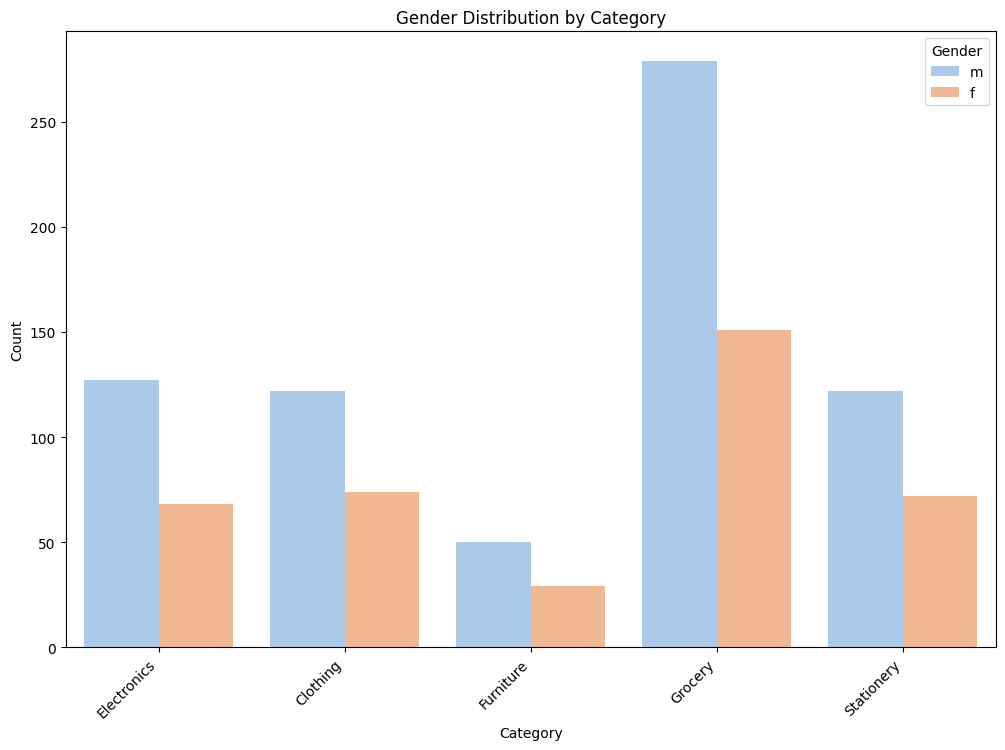

In [66]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Category', hue='gender', data=df, palette='pastel')
plt.title('Gender Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.show()

### Correlation Matrix

> Correlation Matrix helps understand the relations between each variable, which could be useful in several aspects.

> In our case, since we're developing a neural network predictive model for classification, understanding correlations can help in selecting relevant features. Highly correlated features may not add much additional information.

<ipython-input-67-ae19d86349aa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


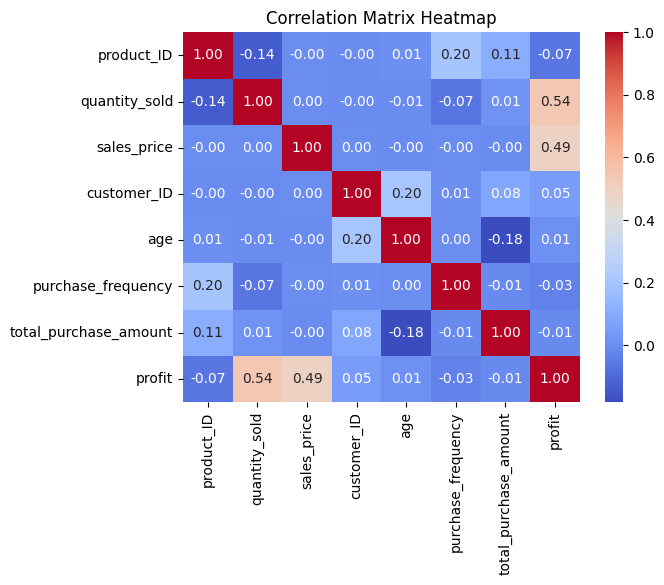

In [67]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

> These statistics provide a summary of the central tendency, spread, and distribution of the 'product_ID' variable.

> Understanding these statistics can help you identify outliers, assess the overall distribution of your data, and gain insights into the typical values for each variable.

In [68]:
print(df.describe())

        product_ID  quantity_sold  sales_price  customer_ID          age  \
count  1094.000000    1094.000000  1094.000000  1094.000000  1094.000000   
mean     25.644424     121.542962    69.050274    12.957038    40.351920   
std      12.254867     167.676123    77.911568     7.195797    13.746014   
min      11.000000       7.000000     7.000000     1.000000    23.000000   
25%      17.000000      33.000000    26.000000     7.000000    29.000000   
50%      26.000000      51.000000    44.000000    13.000000    36.000000   
75%      32.750000     112.000000    74.000000    19.000000    52.000000   
max      51.000000     643.000000   323.000000    25.000000    65.000000   

       purchase_frequency  total_purchase_amount         profit  
count         1094.000000            1094.000000    1094.000000  
mean             4.648995            3371.127971    8408.326325  
std              2.514589            1670.542966   21590.031691  
min              1.000000            1132.000000   

# ---------------------------------------------------------------------------------------------------------------------------------------------

# **2. TIME SERIES FORECASTING**

### **a. Time series Analysis**

> This section provides an overview of the time series analysis conducted on the dataset.

> Time series analysis involves examining data points collected over a period of time to identify patterns, trends, and potential insights.

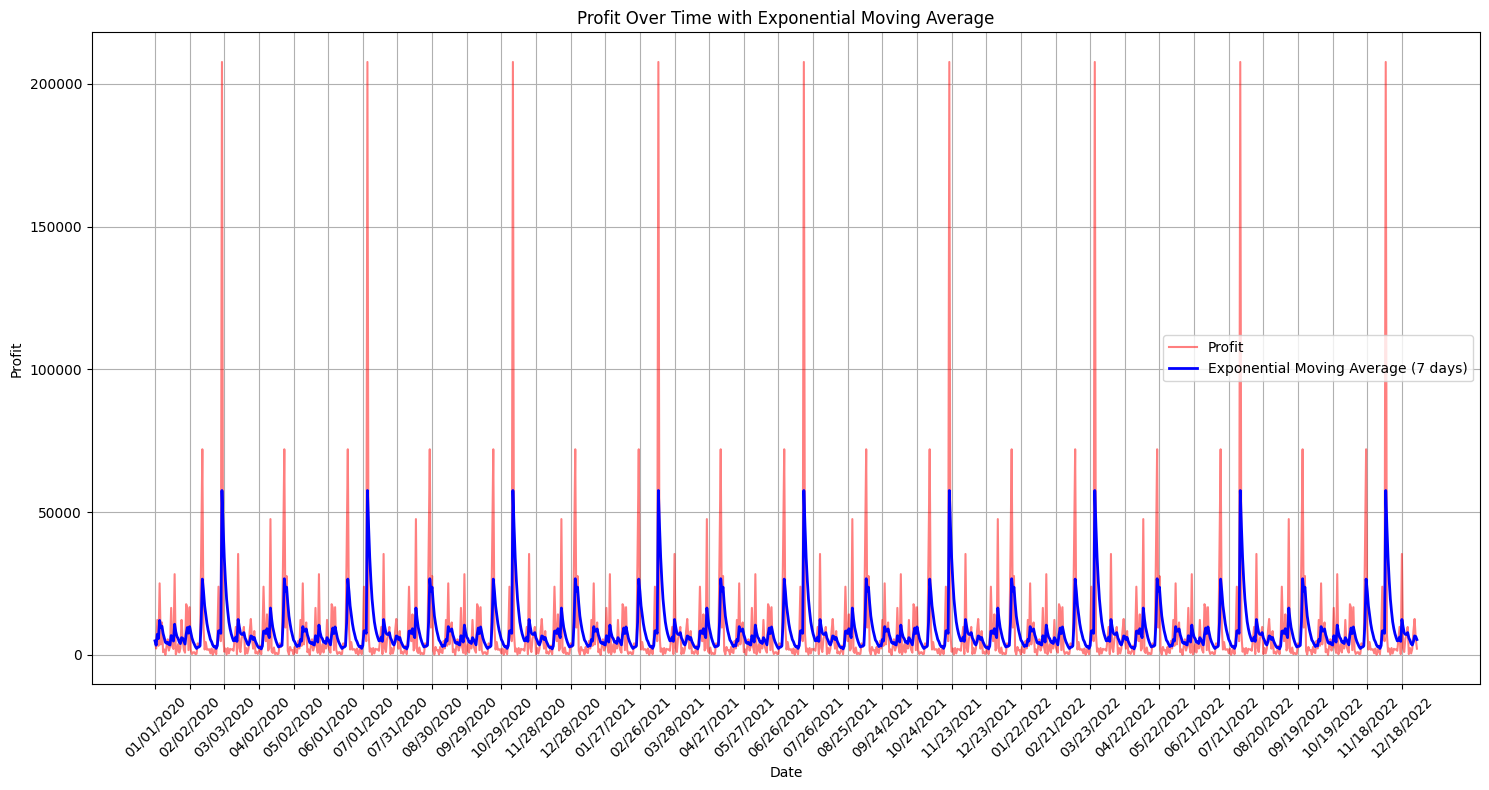

In [69]:
df['profit'] = pd.to_numeric(df['profit'], errors='coerce')

# Calculate a 7-day exponential moving average for smoothing
ema = df['profit'].ewm(span=7).mean()

# Plot the original data and the smoothed trend using EMA
plt.figure(figsize=(15, 8))
plt.plot(df['date'], df['profit'], label='Profit', color='red', alpha=0.5)
plt.plot(df['date'], ema, label='Exponential Moving Average (7 days)', color='blue', linewidth=2)
plt.title('Profit Over Time with Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)

# Set x-axis ticks at every 7 days
plt.xticks(df['date'][::30], rotation=45)

plt.tight_layout()
plt.show()


>EDA was performed to gain a preliminary understanding of the temporal distribution of key variables such as 'profit.'

> Visualizations, including time plots and seasonal decomposition, were employed to identify any apparent trends or patterns.

> From the graph, a noteworthy pattern emerged, revealing a substantial spike in profits approximately every 5 months.

> This most probably implies that a Seasonal Demand Pattern

> Certain seasons or times of the year may witness heightened demand for products, leading to increased sales and subsequently higher profits.

# ---------------------------------------------------------------------------------------------------------------------------------------------

# **3.  CUSTOMER SEGMENTATION (NEURAL NETWORK MODEL)**

> The objective of employing a neural network model is to leverage its capacity for learning complex patterns and relationships within the historical profit data.

> The neural network aims to capture non-linear dependencies and provide accurate forecasts for future profits.

> First we add a new column (feature) named "label" that will determine a high or low profit, which we will use as our target feature in our classification model.

In [73]:
df['label'] = (df['profit'] > df['profit'].mean()).astype(int)

>**One-Hot Encoding**
*  Labels were one-hot encoded to facilitate categorical crossentropy loss during model training.

>**Feature Standardization**
* The features were standardized to ensure consistent scaling across the training, validation, and test sets.

>**ANN layers**
1.   Input layer with 128 nodes and ReLU activation.
2.   Dropout layer with a dropout rate of 0.3 to prevent overfitting.
3. Hidden layer with 64 nodes and ReLU activation.
4. Dropout layer with a dropout rate of 0.3.
5. Output layer with 2 nodes and sigmoid activation for binary classification.

In [71]:
# Split the data into features and labels
X = df[['age', 'purchase_frequency', 'total_purchase_amount']]
y = df['label']

# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y, test_size=0.2, random_state=42)
Train_X, Val_X, Train_Y, Val_Y = train_test_split(Train_X, Train_Y, test_size=0.1, random_state=42)

Train_Y_onehot = tf.keras.utils.to_categorical(Train_Y, num_classes=2)
Val_Y_onehot = tf.keras.utils.to_categorical(Val_Y, num_classes=2)
Test_Y_onehot = tf.keras.utils.to_categorical(Test_Y, num_classes=2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Train_X)
X_test_scaled = scaler.transform(Test_X)
X_val_scaled = scaler.transform(Val_X)

# Neural Network Model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

model.fit(X_train_scaled, Train_Y_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, Val_Y_onehot))

# Evaluate the model on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Display classification report
print("Classification Report:")
print(classification_report(Test_Y_onehot, y_pred))

Epoch 1/10
25/25 [==============================] - 4s 45ms/step - loss: 0.5709 - accuracy: 0.7637 - val_loss: 0.4464 - val_accuracy: 0.8409
Epoch 2/10
25/25 [==============================] - 1s 24ms/step - loss: 0.5266 - accuracy: 0.7853 - val_loss: 0.4526 - val_accuracy: 0.8409
Epoch 3/10
25/25 [==============================] - 0s 16ms/step - loss: 0.5319 - accuracy: 0.7853 - val_loss: 0.4604 - val_accuracy: 0.8409
Epoch 4/10
25/25 [==============================] - 0s 13ms/step - loss: 0.5350 - accuracy: 0.7853 - val_loss: 0.4610 - val_accuracy: 0.8409
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 0.5321 - accuracy: 0.7853 - val_loss: 0.4620 - val_accuracy: 0.8409
Epoch 6/10
25/25 [==============================] - 0s 13ms/step - loss: 0.5250 - accuracy: 0.7853 - val_loss: 0.4598 - val_accuracy: 0.8409
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.5235 - accuracy: 0.7853 - val_loss: 0.4609 - val_accuracy: 0.8409
Epoch 8/10
25

>**Model Training**

>The neural network model was trained using historical profit data. The training process involved the following key steps:

> a. Data Preprocessing:

> 1. Scaling the input features to a standard range to facilitate convergence.
2. Splitting the data into training and validation sets.

> b. Model Compilation:

> Defining the loss function, optimizer, and evaluation metrics for model training.

> c. Model Fitting:

> Training the model on the training data with a specified number of epochs.

> **Model Evaluation**

> The neural network model was evaluated using metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE) on a separate test dataset.

In [72]:
Accuracy_NN = accuracy_score(Test_Y_onehot, y_pred)

print(Accuracy_NN)

0.7442922374429224


> **CONCLUSION**


>The neural network model was trained for binary classification on customer features.



>**Accuracy and Validation:**
* Training accuracy increased from 76% to 78.53%, while validation accuracy stabilized around 84.09% over 10 epochs.



>**Test Set Performance:**
* Precision for the negative class (0) is 76%, but precision for the positive class (1) is 0%, indicating challenges in identifying positive instances.
Recall is 100% for class 0, but 0% for class 1, suggesting the model effectively captures instances of class 0 but struggles with class 1.


>**Support and Overall Metrics:**
* Support indicates 167 instances of class 0 and 52 instances of class 1 in the test set.
* Samples average F1-score, precision, and recall hover around 75%, reflecting overall performance across both classes.

> **Recommendations:**
* Model refinement is needed to better handle positive class predictions.
Consider hyperparameter tuning or exploring alternative models for improved performance.


> Overall accuracy is approximately 74.43%, indicating room for enhancement, especially in handling positive class instances.